In [1]:
from torchvision.datasets import ImageFolder
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import os

In [2]:
device = torch.device("cuda")

In [3]:
import torch.utils.data.dataloader


transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder("./train/", transform=transform)

ratio = 0.2
val_size = int(len(dataset) * ratio)
train_size = len(dataset) - val_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True, num_workers=4)


classes = sorted([x[0].replace("./train/","" ) for x in os.walk("./train")])[1:] 
print(len(classes))

50


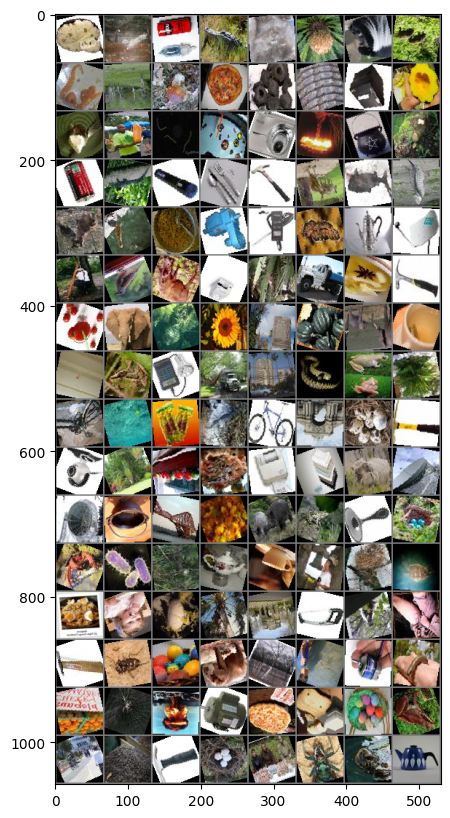

pizza  worm battery crocodilian   cat  palm monkey swine  worm birch fungus pizza carbon crocodilian printer squash icecream squash bacteria gauge camera  bomb   pot fungus battery crocodilian battery spoon hammer kangaroo  fish   cat kangaroo  bird   pot motor gauge  worm   pot antenna  palm  bird swine printer spider truck spice hammer tomato elephant crocodilian flower memorial squash elephant   tea spider  frog gauge truck  palm snake  frog  palm motor  fish  corn crocodilian bicycle memorial  nest hammer camera  palm tomato pizza printer towel swine antenna antenna   pot bridge  bean swine  frog spoon  nest  crab bacteria birch   pot   tea acoustic  nest turtle   egg  corn   egg  palm memorial   saw monkey bacteria hammer beetle   egg elephant birch turtle motor snake tomato spider  bomb motor pizza bread   egg  frog bicycle spice hammer  nest   egg beetle turtle   pot


torch.Size([1, 3, 64, 64])

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))

# get some random training images
images, labels = next(iter(train_loader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

batch_size = 128
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
images[0:1].size()

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Warstwa konwolucyjna 1: 3 kanały wejściowe (RGB), 32 filtry wyjściowe
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # 32x32x3 -> 28x28x32
        self.pool1 = nn.MaxPool2d(2)                                         # 28x28x32 -> 14x14x32
        
        # Warstwa konwolucyjna 2: 32 kanały wejściowe, 64 filtry wyjściowe
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # 14x14x32 -> 10x10x64
        self.pool2 = nn.MaxPool2d(2)                                         # 10x10x64 -> 5x5x64
        
        # Warstwy gęste
        self.fc1 = nn.Linear(16384, 128)  # 5x5x64 = 1600 -> 512
        self.d1 = nn.Dropout(0.3)
        # self.fc2 = nn.Linear(512, 128)         # 512 -> 128
        self.fc3 = nn.Linear(128, 50)          # 128 -> 50 (dla 50 klas)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)  # Spłaszcza wszystkie wymiary oprócz batcha

        x = F.relu(self.fc1(x))
        x = self.d1(x)
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Brak Softmax, bo CrossEntropyLoss to załatwi
        return x




In [6]:
model = Net().to(device="cuda")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
iterations = 5
for epoch in range(iterations):  # loop over the dataset multiple times
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('[%d/%d] loss: %.3f' %
          (epoch+1 , iterations, running_loss / 2000))
    
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network 
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * correct / total))

print('Finished Training')

[1/5] loss: 0.764
Accuracy of the network on the 10000 test images: 29 %
[2/5] loss: 0.749
Accuracy of the network on the 10000 test images: 31 %
[3/5] loss: 0.740
Accuracy of the network on the 10000 test images: 31 %
[4/5] loss: 0.732
Accuracy of the network on the 10000 test images: 32 %
[5/5] loss: 0.725
Accuracy of the network on the 10000 test images: 33 %
Finished Training


# Final evaluation

In [12]:
from torchvision.datasets import ImageFolder
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.image_files = [os.path.join(test_dir, file)
                            for file in os.listdir(test_dir)
                            if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        image_name = os.path.basename(image_path)
        return image, image_name

test_dir = "./test_all"
test_dataset = TestDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

In [20]:
model.eval()
results = []

with torch.no_grad():
    for images, names in test_loader:
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i, name in enumerate(names):
            results.append({
                "image_name": name,
                "predictions": predicted[i].item()
            })

In [23]:
test_df = pd.DataFrame(results)
test_df.to_csv("preds.csv", index=False, header=False)


In [24]:
len(test_df)

10000